In [1]:
import time
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as spa
import h5py
import yaml

from matplotlib.colors import LogNorm

import sys

# go two levels up to get access to hylife modules
sys.path.append('../..')

# put here global directory of simulations folder and name of simulation
all_sim = '/home/florian/Schreibtisch/PHD/02_Projekte/simulations_hylife'
run_dir = 'sim_2021_07_29_1'
sys.path.append(all_sim + '/' + run_dir)

# import necessary hylife modules
import hylife.geometry.domain_3d as dom

import hylife.utilitis_FEEC.spline_space as spl

import hylife.dispersion_relations.dispersion_relations as disp

import input_run.equilibrium_MHD as eq_mhd

In [2]:
# load .hdf5 data file and .yml parameter file
file = h5py.File(all_sim + '/' + run_dir + '/results_' + run_dir + '.hdf5', 'r')

with open(all_sim + '/' + run_dir + '/parameters_' + run_dir + '.yml') as file2:
    params = yaml.load(file2, Loader=yaml.FullLoader)

In [3]:
# load parameters

# gometry
geometry   = params['geometry']
params_map = params['params_map']

# time parameters
Tend = params['Tend']
dt   = params['dt']
Nt   = int(Tend/dt)

# mesh parameters
Nel      = params['Nel']
spl_kind = params['spl_kind']
p        = params['p']

# representation of MHD bulk velocity (vector field (NNN for all components) or 2-form)
basis_u = params['basis_u']

# load data
t    = file['time'][:]

pr   = file['pressure'][:]

b1   = file['magnetic_field/1_component'][:]
b2   = file['magnetic_field/2_component'][:]
b3   = file['magnetic_field/3_component'][:]

u1   = file['velocity_field/1_component'][:]
u2   = file['velocity_field/2_component'][:]
u3   = file['velocity_field/3_component'][:]

ma   = file['bulk_mass'][:]

en   = file['energies/bulk_kinetic'][:] + file['energies/magnetic'][:] + file['energies/bulk_internal'][:]


# create 1d finite element spaces
space_1 = spl.spline_space_1d(Nel[0], p[0], spl_kind[0])
space_2 = spl.spline_space_1d(Nel[1], p[1], spl_kind[1])
space_3 = spl.spline_space_1d(Nel[2], p[2], spl_kind[2])

# create 3d tensor product space
tensor_space = spl.tensor_spline_space([space_1, space_2, space_3])

# create domain
domain = dom.domain(geometry, params_map)

Spline space set up (1d) done.
Spline space set up (1d) done.
Spline space set up (1d) done.
Tensor space set up (3d) done.
Set extraction operators for boundary conditions (3d) done.


In [4]:
# evaluate forms at element boundaries in yz-plane and map to physical domain

# in the current version of STRUPHY, the pressure p is always a 3 form!
basis_p = 3

# quantities on physical domain
px = np.zeros((Nt, Nel[0], Nel[1], Nel[2]), dtype=float)

Ux = np.zeros((Nt, Nel[0], Nel[1], Nel[2]), dtype=float)
Uy = np.zeros((Nt, Nel[0], Nel[1], Nel[2]), dtype=float)
Uz = np.zeros((Nt, Nel[0], Nel[1], Nel[2]), dtype=float)

# we evaluate at element boundaries
el_b = tensor_space.el_b

# do evaluation at each time step
for tn in range(Nt):
    
    if tn%100 == 0:
        print(tn)
    
    # pressure
    if basis_p == 0:
        pp = tensor_space.evaluate_NNN(el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], pr[tn])
        px[tn, :, :, :] = domain.push(pp, el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], '0_form')
    else:
        pp = tensor_space.evaluate_DDD(el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], pr[tn])
        px[tn, :, :, :] = domain.push(pp, el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], '3_form')
    
    # velocity
    if basis_u == 0:
        U1 = tensor_space.evaluate_NNN(el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], u1[tn])
        U2 = tensor_space.evaluate_NNN(el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], u2[tn])
        U3 = tensor_space.evaluate_NNN(el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], u3[tn])
        
        Ux[tn, :, :, :] = domain.push([U1, U2, U3], el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], 'vector_1')
        Uy[tn, :, :, :] = domain.push([U1, U2, U3], el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], 'vector_2')
        Uz[tn, :, :, :] = domain.push([U1, U2, U3], el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], 'vector_3')
    
    elif basis_u == 1:
        U1 = tensor_space.evaluate_DNN(el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], u1[tn])
        U2 = tensor_space.evaluate_NDN(el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], u2[tn])
        U3 = tensor_space.evaluate_NND(el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], u3[tn])
        
        Ux[tn, :, :, :] = domain.push([U1, U2, U3], el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], '1_form_1')
        Uy[tn, :, :, :] = domain.push([U1, U2, U3], el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], '1_form_2')
        Uz[tn, :, :, :] = domain.push([U1, U2, U3], el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], '1_form_3')
        
    else:
        U1  = tensor_space.evaluate_NDD(el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], u1[tn])
        U2  = tensor_space.evaluate_DND(el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], u2[tn])
        U3  = tensor_space.evaluate_DDN(el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], u3[tn])

        Ux[tn, :, :, :] = domain.push([U1, U2, U3], el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], '2_form_1')
        Uy[tn, :, :, :] = domain.push([U1, U2, U3], el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], '2_form_2')
        Uz[tn, :, :, :] = domain.push([U1, U2, U3], el_b[0][:-1], el_b[1][:-1], el_b[2][:-1], '2_form_3')

0
100
200
300
400
500
600
700
800
900
1000
1100


In [5]:
# power spectra in yz-plane at x = Lx/2
pr_power_spectrum = np.abs(np.fft.fftn(px[:, (el_b[0].size - 1)//2, :, :]))[:Nt//2 + 1, :Nel[1]//2 + 1, :Nel[2]//2 + 1]
Ux_power_spectrum = np.abs(np.fft.fftn(Ux[:, (el_b[0].size - 1)//2, :, :]))[:Nt//2 + 1, :Nel[1]//2 + 1, :Nel[2]//2 + 1]
Uy_power_spectrum = np.abs(np.fft.fftn(Uy[:, (el_b[0].size - 1)//2, :, :]))[:Nt//2 + 1, :Nel[1]//2 + 1, :Nel[2]//2 + 1]
Uz_power_spectrum = np.abs(np.fft.fftn(Uz[:, (el_b[0].size - 1)//2, :, :]))[:Nt//2 + 1, :Nel[1]//2 + 1, :Nel[2]//2 + 1]

w  = 2*np.pi*np.fft.rfftfreq(Nt, dt)
ky = 2*np.pi*np.fft.rfftfreq(Nel[1], params_map[1]/Nel[1])
kz = 2*np.pi*np.fft.rfftfreq(Nel[2], params_map[2]/Nel[2])

W, KY, KZ = np.meshgrid(w, ky, kz, indexing='ij')

<ipython-input-7-1c82b7d26ad0>:17: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(KZ[:, 0, :], W[:, 0, :], pr_power_spectrum[:, 0, :]**2/(pr_power_spectrum[:, 0, :]**2).max(), cmap = 'jet', norm = LogNorm(), levels=lvls)


Text(0, 0.5, '$\\omega$')

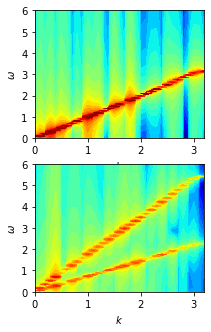

In [7]:
# plot resutling spectra in k-w plane
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(14)

plt.subplot(341)
lvls = np.logspace(-12, -3, 27)
plt.contourf(KZ[:, 0, :], W[:, 0, :], Ux_power_spectrum[:, 0, :]**2/(Ux_power_spectrum[:, 0, :]**2).max(), cmap = 'jet', norm = LogNorm(), levels=lvls)
#plt.plot(np.linspace(0., kz[-1], 50), vShear*np.linspace(0., kz[-1], 50), linestyle='dashed', linewidth=0.5, color='black')
plt.ylim((0., 6.))
plt.xlabel('$k$')
plt.ylabel('$\omega$')


plt.subplot(345)
lvls = np.logspace(-15, -3, 27)
plt.contourf(KZ[:, 0, :], W[:, 0, :], pr_power_spectrum[:, 0, :]**2/(pr_power_spectrum[:, 0, :]**2).max(), cmap = 'jet', norm = LogNorm(), levels=lvls)
#plt.plot(np.linspace(0., kz[-1], 50), vFast*np.linspace(0., kz[-1], 50), linestyle='dashed', linewidth=0.5, color='black')
#plt.plot(np.linspace(0., kz[-1], 50), vSlow*np.linspace(0., kz[-1], 50), linestyle='dashed', linewidth=0.5, color='black')
plt.ylim((0., 6.))
plt.xlabel('$k$')
plt.ylabel('$\omega$')